Donwload the ephimeres data for Neptune, Uranus, Saturn and Jupiter from the following lik and upload it in the notebook's files before running the code:
https://drive.google.com/drive/folders/1jTIP4iSCrfoqdKXt4sUcwocLxYqIx8uG?usp=sharing

In [1]:
import numpy as np
import scipy.optimize as sc
from scipy.signal import medfilt, find_peaks
import math
from astroquery.jplhorizons import Horizons
from astropy.time import Time

## On importe les Ephemeris des corps important sur la trajectoire d'Uranus

In [2]:
annee_start = 1780
annee_fin = 2040

# On importe la position des 4 planètes
neptune = Horizons(id="8", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Neptune")
uranus = Horizons(id="7", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Uranus")
saturne = Horizons(id="6", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Saturne")
jupiter = Horizons(id="5", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Jupiter")
mars = Horizons(id="4", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Mars")
terre = Horizons(id="3", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Terre")
venus = Horizons(id="2", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Venus")
mercure = Horizons(id="1", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Mercure")

Neptune = np.stack([np.array(neptune[:]["x"]),np.array(neptune[:]["y"]),np.array(neptune[:]["z"])],axis=1)
Uranus = np.stack([np.array(uranus[:]["x"]),np.array(uranus[:]["y"]),np.array(uranus[:]["z"])],axis=1)
Saturn = np.stack([np.array(saturne[:]["x"]),np.array(saturne[:]["y"]),np.array(saturne[:]["z"])],axis=1)
Jupiter = np.stack([np.array(jupiter[:]["x"]),np.array(jupiter[:]["y"]),np.array(jupiter[:]["z"])],axis=1)
Mars = np.stack([np.array(mars[:]["x"]),np.array(mars[:]["y"]),np.array(mars[:]["z"])],axis=1)
Terre = np.stack([np.array(terre[:]["x"]),np.array(terre[:]["y"]),np.array(terre[:]["z"])],axis=1)
Venus = np.stack([np.array(venus[:]["x"]),np.array(venus[:]["y"]),np.array(venus[:]["z"])],axis=1)
Mercure = np.stack([np.array(mercure[:]["x"]),np.array(mercure[:]["y"]),np.array(mercure[:]["z"])],axis=1)
# On importe les vitesses d'uranus
Uv = np.stack([np.array(uranus[:]["vx"]),np.array(uranus[:]["vy"]),np.array(uranus[:]["vz"])],axis=1)
Uv=Uv*365.24218750 # Convertir de AU/Jour en AU/an

Import Neptune
Import Uranus
Import Saturne
Import Jupiter
Import Mars
Import Terre
Import Venus
Import Mercure


## On calcule notre variable V avec les vraies valeurs pour voir si on est correcte sur l'intervalle de temps utilisé

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
Time=np.array(range(Uranus.shape[0]))
Time=Time/(365.24218750/30)+annee_start
Time_no_buffer = Time.copy()
T=Neptune-Uranus

In [4]:
# Ça c'est la partie où ce serait cool d'inclure nos valeurs du simulateur
from scipy.constants import G
G=G*(365.24218750*86400)**2/(149597870700)**3 #Conversion de kg(AU)^3/(année)^2
M_N=1.024e26

# Calcul de V en utilisant Les valeurs de Neptune pour vérifier 
# si le bon graphique peut être obtenu

# rel_pos : position relative de neptune à uranus
# r_NU3 : distance entre Neptune et Uranus au cube
# r_NS3 : distance entre Neptune et le soleil au cube
# A_by_N_théo : accélération théorique causé par Neptune sur Uranus

rel_pos = Neptune-Uranus

Nx,Ny,Nz = Neptune.T
Ux,Uy,Uz = Uranus.T

r_NU3 = ((Nx-Ux)**2+(Ny-Uy)**2+(Nz-Uz)**2)**(3/2) #10^3

r_NU3 = np.tile(r_NU3, (3,1))
r_NU3 = np.transpose(r_NU3)

r_NS3 = ((Nx)**2+(Ny)**2+(Nz)**2)**(3/2) #10^3

r_NS3 = np.tile(r_NS3, (3,1))
r_NS3 = np.transpose(r_NS3)

A_by_N_théo = G*M_N*(rel_pos/r_NU3 - Neptune/r_NS3)
Ax,Ay,Az = A_by_N_théo.T
A_by_N_théo_mag = np.sqrt((Ax**2)+(Ay**2)+(Az**2))

## On calcul l'accélération de Neptune sans considéré l'influence de Neptune

In [5]:
#On compute la variable V en utilisant la méthode RHS
buffer = 5
Time = Time[buffer:-buffer]

# r_US3 : distance entre Uranus et le soleil au cube
# A_by_N_T2 : Deuxième terme de l'accélération causé par Neptune sur Uranus
# r_StS3 : distance entre Saturne et le soleil au cube
# r_USt3 : distance entre Uranus et Saturne au cube
# r_UJ3 : distance entre Uranus et Jupiter au cube
# r_JS3 : distance entre Jupiter et le soleil au cube

M_S = 1.989e30 #Masse du Soleil
M_U = 8.681e25 #Masse d'Uranus
M_St = 5.683e26 #Masse de Saturne
M_J = 1.898e27 #Masse de Jupiter
M_Ma = 6.417e23 #Masse de Mars
M_T = 5.972e24 #Masse de la Terre
M_V = 4.867e24 #Masse de Vénus
M_Me = 3.285e23 #Masse de Mercure

#############
#Deuxième Terme
#############

r_US3 = np.sqrt((Ux**2)+(Uy**2)+(Uz**2))**3
r_US3 = np.tile(r_US3, (3,1))
r_US3 = np.transpose(r_US3)

A_by_N_T2 = G*(M_S+M_U)*Uranus/(r_US3)

############
#Troisième Terme
############

#Saturn
Sx,Sy,Sz=Saturn.T

r_USt3 =((Sx-Ux)**2+(Sy-Uy)**2+(Sz-Uz)**2)**(3/2)
r_USt3 = np.tile(r_USt3, (3,1))
r_USt3 =np.transpose(r_USt3)

r_StS3 =((Sx)**2+(Sy)**2+(Sz)**2)**(3/2)
r_StS3 = np.tile(r_StS3, (3,1))
r_StS3 =np.transpose(r_StS3)

S = G*M_St*((Saturn-Uranus)/r_USt3 - Saturn/r_StS3)

#Jupiter
Jx,Jy,Jz=Jupiter.T

r_UJ3 = ((Jx-Ux)**2+(Jy-Uy)**2+(Jz-Uz)**2)**(3/2)
r_UJ3 = np.tile(r_UJ3, (3,1))
r_UJ3 = np.transpose(r_UJ3)

r_JS3 = ((Jx)**2+(Jy)**2+(Jz)**2)**(3/2)
r_JS3 = np.tile(r_JS3, (3,1))
r_JS3 = np.transpose(r_JS3)

J = G*M_J*((Jupiter-Uranus)/r_UJ3 - Jupiter/r_JS3)

#Mars
Max,May,Maz=Mars.T

r_UMa3 = ((Max-Ux)**2+(May-Uy)**2+(Maz-Uz)**2)**(3/2)
r_UMa3 = np.tile(r_UMa3, (3,1))
r_UMa3 = np.transpose(r_UMa3)

r_MaS3 = ((Max)**2+(May)**2+(Maz)**2)**(3/2)
r_MaS3 = np.tile(r_MaS3, (3,1))
r_MaS3 = np.transpose(r_MaS3)

Ma = G*M_Ma*((Mars-Uranus)/r_UMa3 - Mars/r_MaS3)

#Terre
Tx,Ty,Tz=Terre.T

r_UT3 = ((Tx-Ux)**2+(Ty-Uy)**2+(Tz-Uz)**2)**(3/2)
r_UT3 = np.tile(r_UT3, (3,1))
r_UT3 = np.transpose(r_UT3)

r_TS3 = ((Tx)**2+(Ty)**2+(Tz)**2)**(3/2)
r_TS3 = np.tile(r_TS3, (3,1))
r_TS3 = np.transpose(r_TS3)

T = G*M_T*((Terre-Uranus)/r_UT3 - Terre/r_TS3)

#Venus
Vx,Vy,Vz=Venus.T

r_UV3 = ((Vx-Ux)**2+(Vy-Uy)**2+(Vz-Uz)**2)**(3/2)
r_UV3 = np.tile(r_UV3, (3,1))
r_UV3 = np.transpose(r_UV3)

r_VS3 = ((Vx)**2+(Vy)**2+(Vz)**2)**(3/2)
r_VS3 = np.tile(r_VS3, (3,1))
r_VS3 = np.transpose(r_VS3)

V = G*M_V*((Venus-Uranus)/r_UV3 - Venus/r_VS3)

#Mercure
Mex,Mey,Mez=Mercure.T

r_UMe3 = ((Mex-Ux)**2+(Mey-Uy)**2+(Mez-Uz)**2)**(3/2)
r_UMe3 = np.tile(r_UMe3, (3,1))
r_UMe3 = np.transpose(r_UMe3)

r_MeS3 = ((Mex)**2+(Mey)**2+(Mez)**2)**(3/2)
r_MeS3 = np.tile(r_MeS3, (3,1))
r_MeS3 = np.transpose(r_MeS3)

Me = G*M_Me*((Mercure-Uranus)/r_UMe3 - Mercure/r_MeS3)

A_by_N_T3 = J+S+Ma+T+V+Me

In [6]:
# On obtient l'accélération d'Uranus en utilisant la 
#méthode "Five-point stencil" du vecteur de vitesse

dt = 30/365.24218750 # L'intervalle de temps entre deux points consécutifs en année
A_by_N_T1 = np.tile(np.zeros(Uranus.shape[0]),(3,1))

A_by_N_T1 = np.transpose(A_by_N_T1)
for i in range(Uranus.shape[0]-2):
    if i not in [0,1]:
        A_by_N_T1[i]=1/(12*dt)*(Uv[i-2]-8*Uv[i-1]+8*Uv[i+1]-Uv[i+2])

# On applique le buffer
A_by_N_T1 = A_by_N_T1[buffer:-buffer,:]
A_by_N_T2 = A_by_N_T2[buffer:-buffer,:]
A_by_N_T3 = A_by_N_T3[buffer:-buffer,:]

A_by_N_théo = A_by_N_théo[buffer:-buffer,:]
A_by_N_théo_mag = A_by_N_théo_mag[buffer:-buffer]

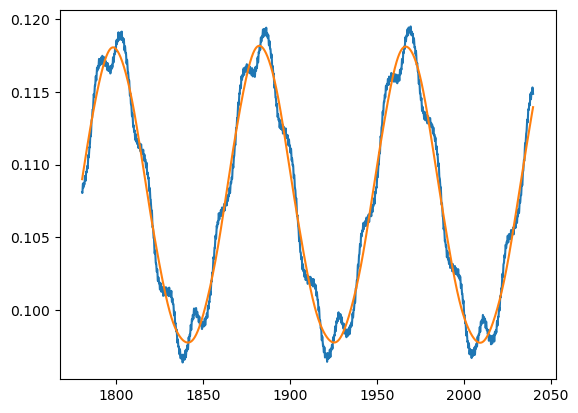

In [7]:
# On prend les coordonnées du premier terme de V2
A_by_N_T1x, A_by_N_T1y, A_by_N_T1z = A_by_N_T1.T
A_by_N_T1_mag =((A_by_N_T1x)**2+(A_by_N_T1y)**2+(A_by_N_T1z)**2)**(1/2)
plt.plot(Time,A_by_N_T1_mag,label="Premier terme")

# On prend les coordonnées du deuxième terme de V2
A_by_N_T2x, A_by_N_T2y, A_by_N_T2z = A_by_N_T2.T
A_by_N_T2_mag = ((A_by_N_T2x)**2+(A_by_N_T2y)**2+(A_by_N_T2z)**2)**(1/2)
plt.plot(Time,A_by_N_T2_mag,label="Deuxième terme")

# On prend les coordonnées du troisième terme de V2
A_by_N_T3x, A_by_N_T3y, A_by_N_T3z = A_by_N_T3.T
A_by_N_T3_mag =((A_by_N_T3x)**2+(A_by_N_T3y)**2+(A_by_N_T3z)**2)**(1/2)

## A_by_N expérimental

In [8]:
A_by_N = A_by_N_T1+A_by_N_T2-A_by_N_T3
A_by_Nx, A_by_Ny, A_by_Nz = A_by_N.T
A_by_N_mag =((A_by_Nx)**2+(A_by_Ny)**2+(A_by_Nz)**2)**(1/2)

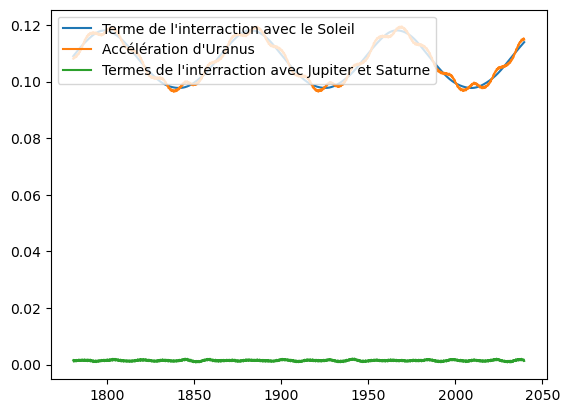

In [9]:
plt.plot(Time,A_by_N_T2_mag,label="Terme de l'interraction avec le Soleil")
plt.plot(Time,A_by_N_T1_mag,label="Accélération d'Uranus")
plt.plot(Time,A_by_N_T3_mag,label="Termes de l'interraction avec Jupiter et Saturne")
plt.legend(loc="upper left")
plt.show()

## Filtrage

In [10]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
kernel = 301
filter_buffer = int((kernel-1)/2)

théo_x,théo_y,théo_z = A_by_N_théo.T
exp_x, exp_y, exp_z = A_by_N.T
mean_x = moving_average(exp_x,kernel)
mean_y = moving_average(exp_y,kernel)
mean_z = moving_average(exp_z,kernel)
mean_mag = np.sqrt(mean_x**2+mean_y**2+mean_z**2)

error = np.std(A_by_N_mag[filter_buffer:-filter_buffer])/4

## Calculons la période synodique

(2786,)


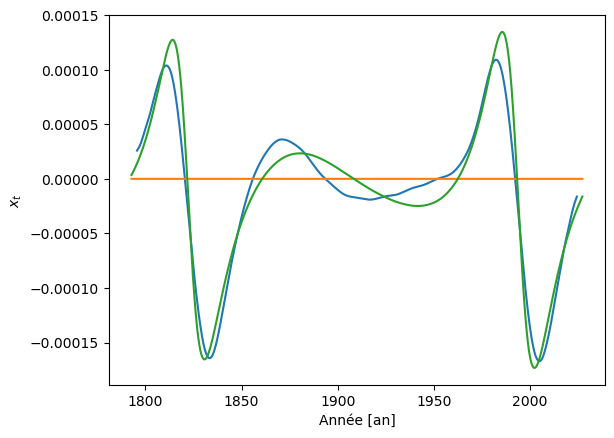

In [11]:
Ax,Ay,Az = mean_x,mean_y,mean_z
Ax_t,Ay_t,Az_t = A_by_N_théo[filter_buffer:-filter_buffer,:].T

Z=np.zeros(Uranus.shape[0])
Z=np.tile(Z,(3,1))
Z=np.transpose(Z)
for i in range(Uranus.shape[0]):
  Z[i,2]=1

p_t=np.cross(Z,Uranus)
px,py,pz=p_t[buffer:-buffer,:][filter_buffer:-filter_buffer,:].T

x_t_théo =Ax_t*px+Ay_t*py+Az_t*pz


x_t=Ax*px+Ay*py+Az*pz

xt_fft = np.fft.fft(x_t)
xt_fft[50:-50] = 0
x_t1 = np.fft.ifft(xt_fft).real

buffer_fft = 35
kernel_fft = buffer_fft-10
x_t1 = moving_average(x_t1,kernel_fft)
buffer_supp = int((buffer_fft-(kernel_fft-1)/2))
x_t1 = x_t1[buffer_supp:-buffer_supp]


print(Time[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft].shape)
plt.plot(Time[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft],x_t1)

Zero=np.zeros(len(mean_x))
Zero=np.array(Zero)
plt.plot(Time[filter_buffer:-filter_buffer],Zero)
plt.plot(Time[filter_buffer:-filter_buffer],x_t_théo)
plt.xlabel("Année [an]")
plt.ylabel("$x_t$")
plt.show()

In [17]:
def intersection(X,Y):
	ind = []
	xs = []
	for i in range(len(Y)-1):
		if Y[i] ==0:
			xs.append(X[i])
			ind.append(i)
		elif (Y[i] < 0 and Y[i+1] > 0):
			xs.append(X[i])
			ind.append(i)
		elif (Y[i] > 0 and Y[i+1] < 0):
			xs.append(X[i])
			ind.append(i)
	return xs, ind

intersect, indice_conjonction = intersection(Time[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft],x_t1)
intersect_théo,_ = intersection(Time[filter_buffer:-filter_buffer],x_t_théo)

C1,C2 = intersect[0],intersect[-1]
C1_théo,C2_théo = intersect_théo[0],intersect_théo[-1]
print("Première Conjonction: ",C1,"| Deuxième Conjonction : ",C2)
print("Première Conjonction théo: ",C1_théo,"| Deuxième Conjonction théo: ",C2_théo)

C=C2-C1
C=(1-5/365.24218750)*C

C_théo=C2_théo-C1_théo
C_théo=(1-5/365.24218750)*C_théo

print("The Synodic Period of Neptune with respect to Uranus is :",C," years")
print("The Theoric Synodic Period of Neptune with respect to Uranus is :",C_théo," years")

[1820.4936792795877, 1855.8127098885586, 1893.513721631623, 1951.8311907766679, 1992.2427327757696]
Première Conjonction:  1820.4936792795877 | Deuxième Conjonction :  1992.2427327757696
Première Conjonction théo:  1821.7257384868774 | Deuxième Conjonction théo:  1993.2283801416013
The Synodic Period of Neptune with respect to Uranus is : 169.39788679947898  years
The Theoric Synodic Period of Neptune with respect to Uranus is : 169.15484822444384  years


## On calcul la période sidérale

In [18]:
P_U = 84.05 # an

D = (P_U*C)/( C-P_U )
print("La période sidérale pour Neptune est: ",D)


La période sidérale pour Neptune est:  166.82185018766188


In [19]:
#Calculating the semi-major axis using Kepler's third law
a_u=D**(2/3)
print("Le demi grand-axe de Neptune est:",a_u)

Le demi grand-axe de Neptune est: 30.304139442536012


## On estime la masse de Neptune

In [23]:
# #Finding the Mass of Neptune: ça marche juste pour une position c'est wack
ratio = a_u/19.189
ind_1 = indice_conjonction[0]

Uxyz_1 = Uranus[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft][ind_1]
Nxyz_1 = Uxyz_1*ratio
A_by_N_1 = A_by_N[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft][ind_1]


r_UN_1 = np.sqrt((Nxyz_1[0]-Uxyz_1[0])**2+(Nxyz_1[1]-Uxyz_1[1])**2+(Nxyz_1[2]-Uxyz_1[2])**2)
r_N_1 = np.sqrt((Nxyz_1[0])**2+(Nxyz_1[1])**2+(Nxyz_1[2])**2)

M_N_1 = (A_by_N_1/G)/( (Nxyz_1 - Uxyz_1)/(r_UN_1**3) - Nxyz_1/(np.abs(r_N_1)**3) )
print(np.abs(np.sum(M_N_1)/M_N_1.shape[0]))
print(M_N_1)
ind_2 = indice_conjonction[-1]

Uxyz_2 = Uranus[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft][ind_2]
Nxyz_2 = Uxyz_2*ratio
A_by_N_2 = A_by_N[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft][ind_2]


r_UN_2 = np.sqrt((Nxyz_2[0]-Uxyz_2[0])**2+(Nxyz_2[1]-Uxyz_2[1])**2+(Nxyz_2[2]-Uxyz_2[2])**2)
r_N_2 = np.sqrt((Nxyz_2[0])**2+(Nxyz_2[1])**2+(Nxyz_2[2])**2)

M_N_2 = (A_by_N_2/G)/( (Nxyz_2 - Uxyz_2)/(r_UN_2**3) - Nxyz_2/(np.abs(r_N_2)**3) )
print(M_N_2)
print(np.abs(np.sum(M_N_2)/M_N_2.shape[0]))


# #We print the average of these values
# print("The Mass of Neptune is: ",np.sum(Mass_N)/Uranus.shape[0])

1.0639718397728332e+26
[ 5.08891549e+27  4.15412480e+26 -5.82351952e+27]
[2.93815014e+26 4.92194249e+26 3.84167868e+26]
3.9005904372846764e+26
